# Choosing the number of replications

The **confidence interval method** can be used to select the number of replications to run. The more replications you run, the narrower your confidence interval becomes, leading to a more precise estimate of the model's mean performance.

First, you select a desired confidence interval - for example, 95%. Then, run the model with an increasing number of replications, and identify the number required to achieve that precision in the estimate of a given metric - and also, to maintain that precision (as the intervals may converge or expand again later on).

This method is less useful for values very close to zero - so, for example, when using utilisation (which ranges from 0 to 1) it is recommended to multiple values by 100.

When selecting the number of replications you should repeat the analysis for all performance measures and select the highest value as your number of replications.

This notebook shares two ways of implementing this: **manually** and **automated**.

Credit:

* Code for manual choice of replication number was adapted from Tom Monks (2024) [HPDM097 - Making a difference with health data](https://github.com/health-data-science-OR/stochastic_systems) (MIT Licence).
* Code for automated detection of replication number was adapted from Tom Monks (2025) [sim-tools: tools to support the Discrete-Event Simulation process in python](https://github.com/TomMonks/sim-tools) (MIT Licence).

## Set-up

Load required packages.

In [1]:
# pylint: disable=missing-module-docstring
# To ensure any updates to `simulation/` are fetched without needing to restart
# the notebook environment, reload `simulation/` before execution of each cell
%load_ext autoreload
%autoreload 1
%aimport simulation

In [2]:
# pylint: disable=wrong-import-position
import os
import time
import warnings

from IPython.display import display
import pandas as pd
import plotly.express as px
import plotly.io as pio

from simulation.model import Param, Runner
from simulation.helper import summary_stats
from simulation.replications import (ReplicationTabulizer,
                                     ReplicationsAlgorithm,
                                     plotly_confidence_interval_method)

Display plotly express figures as non-interactive figures. This means they will be visible when browsing the notebooks on GitHub. To switch these back to interactive figures, simply remove this line.

In [3]:
pio.renderers.default = 'svg'

Start timer.

In [4]:
notebook_start_time = time.time()

Define path to outputs folder

In [5]:
# pylint: disable=duplicate-code
OUTPUT_DIR = '../outputs/'

Define labels for variables in the dataset.

In [6]:
LABELS = {
    'arrivals': 'Patient arrivals (n)',
    'mean_q_time_nurse': 'Mean wait time for nurse (minutes)',
    'mean_n_consult_time': 'Mean consultation time with nurse (minutes)',
    'mean_time_with_nurse': 'Mean consultation time with nurse (minutes)',
    'mean_nurse_utilisation': 'Mean nurse utilisation',
    'adj_mean_nurse_utilisation': 'Mean nurse utilisation (*100 - %)',
    'adj_mean_q_time_nurse': 'Mean wait time for nurse (*100) (minutes)',
    'mean_nurse_utilisation_tw': 'Time-weighted mean nurse utilisation',
    'mean_nurse_q_length': 'Time-weighted mean queue length for nurse (n)',
    'patient_inter': 'Patient inter-arrival time',
    'number_of_nurses': 'Number of nurses',
    'utilisation': 'Utilisation',
    'running_mean_wait_time': 'Running mean nurse wait time (minutes)'
}

## Manual inspection

First, we demonstrate how to do this manually, by inspecting the output table and figures to determine an appropriate number of replications.

In [7]:
# pylint: disable=too-many-arguments,too-many-positional-arguments
def confidence_interval_method(
    file, replications, metric, desired_precision,
    min_rep=None, path=OUTPUT_DIR, labels=None
):
    """
    Use the confidence interval method to select the number of replications.

    Arguments:
        file (str):
            Filename to save figure to.
        replications (int):
            Number of times to run the model.
        metric (string):
            Name of performance metric to assess.
        desired_precision (float):
            Desired mean deviation from confidence interval.
        min_rep (int):
            A suggested minimum number of replications, using to draw vertical
            line on plot. If none provided, will not add a line.
        path (str):
            Path to save file to (exc. filename).
        labels (dict):
            Contains mappings from variable names to full labels. If none
            provided, will default to using variable names.
    """
    param = Param(number_of_runs=replications)
    choose_rep = Runner(param)
    choose_rep.run_reps()

    # If mean of metric is less than 1, multiply by 100
    df = choose_rep.run_results_df
    if df[metric].mean() < 1:
        df[f'adj_{metric}'] = df[metric] * 100
        metric = f'adj_{metric}'

    # Compute cumulative statistics
    cumulative = pd.DataFrame([
        {
            'replications': i,
            'cumulative_mean': stats[0],
            'cumulative_std': stats[1],
            'lower_ci': stats[2],
            'upper_ci': stats[3],
            'perc_deviation': ((stats[3] - stats[0]) / stats[0]) * 100
        }
        for i, stats in enumerate(
            (summary_stats(df[metric].iloc[:i])
             for i in range(1, replications + 1))
        )
    ])
    display(cumulative)

    # Get minimum number of replications where deviation is less than target
    try:
        min_reps = cumulative[cumulative['perc_deviation']
                              <= desired_precision*100].iloc[0].name + 1
        print(f'Reached desired precision ({desired_precision}) in ' +
              f'{min_reps} replications.')
    except IndexError:
        warnings.warn(f'Running {replications} replications did not reach' +
                      f'desired precision ({desired_precision}).')

    # Plot the cumulative mean and confidence interval
    figure = px.line(cumulative,
                     x='replications',
                     y=['cumulative_mean', 'lower_ci', 'upper_ci'])
    figure.update_layout(
        xaxis_title='Number of replications',
        yaxis_title=labels.get(metric, metric),
        template='plotly_white'
    )
    if min_rep is not None:
        figure.add_vline(x=min_rep, line_color='red', line_dash='dash')

    # Show figure
    figure.show()

    # Save figure
    figure.write_image(os.path.join(path, file))

,replications,cumulative_mean,cumulative_std,lower_ci,upper_ci,perc_deviation
0,0,9.842380,NaN,NaN,NaN,NaN
1,1,9.951402,0.154180,8.566149,11.336655,13.920181
2,2,9.942631,0.110075,9.669189,10.216073,2.750194
3,3,9.941599,0.089900,9.798549,10.084650,1.438907
4,4,9.956602,0.084775,9.851339,10.061864,1.057210
5,5,9.944468,0.081442,9.859000,10.029936,0.859452
6,6,9.958195,0.082742,9.881671,10.034719,0.768450
7,7,9.974247,0.089048,9.899801,10.048693,0.746385
8,8,9.999643,0.112884,9.912872,10.086413,0.867734
9,9,10.009002,0.110467,9.929979,10.088025,0.789522


Reached desired precision (0.05) in 3 replications.


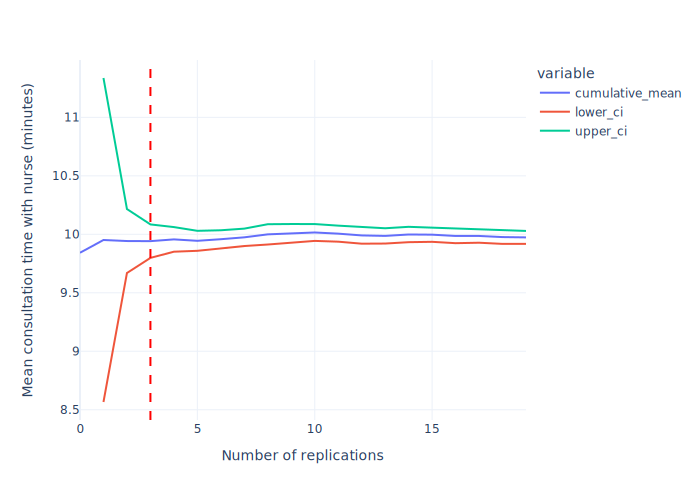

In [8]:
confidence_interval_method(
    file='choose_param_conf_int_1.png',
    replications=20,
    metric='mean_time_with_nurse',
    desired_precision=0.05,
    min_rep=3,
    labels=LABELS
)

It is important to check ahead 10-20 replications, to check that the 5% precision is maintained. For this example, 3 replications is < 5, but then it quickly goes back up, and is not stable until 31 replications.

,replications,cumulative_mean,cumulative_std,lower_ci,upper_ci,perc_deviation
0,0,50.187329,NaN,NaN,NaN,NaN
1,1,50.906857,1.017567,41.764379,60.049335,17.959227
2,2,51.647229,1.470432,47.994472,55.299986,7.072512
3,3,51.013012,1.746532,48.233890,53.792134,5.447869
4,4,50.075454,2.585121,46.865602,53.285306,6.410031
5,5,48.237798,5.060452,42.927179,53.548416,11.009247
6,6,48.107789,4.632328,43.823600,52.391977,8.905395
7,7,49.738086,6.297295,44.473416,55.002756,10.584787
8,8,49.533032,5.922614,44.980508,54.085556,9.190885
9,9,50.227203,5.999883,45.935145,54.519261,8.545285


Reached desired precision (0.05) in 31 replications.


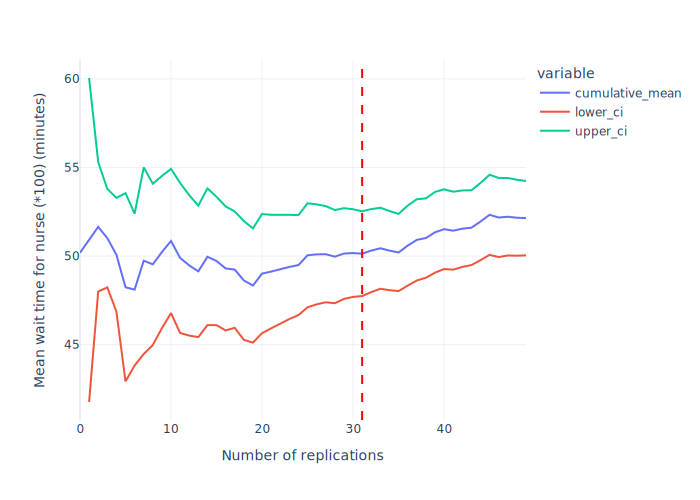

In [9]:
confidence_interval_method(
    file='choose_param_conf_int_2.png',
    replications=50,
    metric='mean_q_time_nurse',
    desired_precision=0.05,
    min_rep=31,
    labels=LABELS
)

,replications,cumulative_mean,cumulative_std,lower_ci,upper_ci,perc_deviation
0,0,49.958879,NaN,NaN,NaN,NaN
1,1,50.078314,0.168907,48.560747,51.595881,3.030387
2,2,49.988671,0.195888,49.502058,50.475284,0.973446
3,3,49.947723,0.179690,49.661797,50.233649,0.572451
4,4,49.896857,0.192752,49.657523,50.136190,0.479656
5,5,49.794946,0.303376,49.476572,50.113320,0.639370
6,6,49.872608,0.344844,49.553681,50.191536,0.639485
7,7,49.931174,0.359679,49.630475,50.231873,0.602227
8,8,50.036796,0.462171,49.681540,50.392052,0.709990
9,9,50.032553,0.435945,49.720697,50.344410,0.623307


Reached desired precision (0.05) in 2 replications.


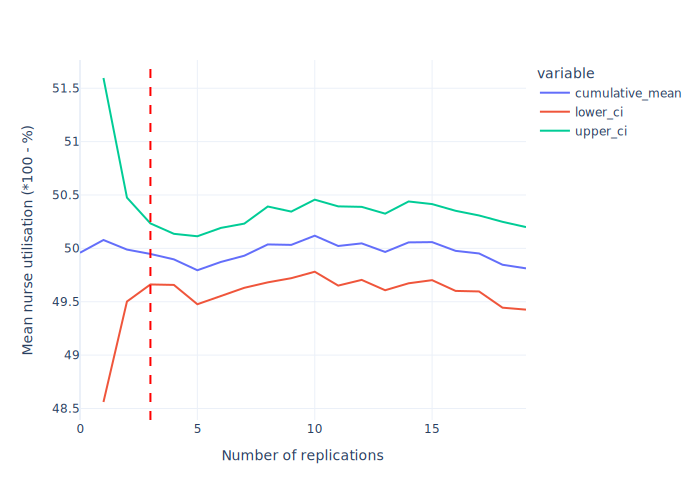

In [10]:
confidence_interval_method(
    file='choose_param_conf_int_3.png',
    replications=20,
    metric='mean_nurse_utilisation',
    desired_precision=0.05,
    min_rep=3,
    labels=LABELS
)

## Automated detection of appropriate number of replications

In [11]:
# Set up ReplicationTabulizer and ReplicationsAlgorithm
observer = ReplicationTabulizer()
analyser = ReplicationsAlgorithm(verbose=False, observer=observer)

<mark>this looks identical to manual - only difference is this has deviation as a decimal rather than as percentage</mark>

<mark>perhaps remove calculation/plot from 2 replications from manual method if would normally say that isn't valid</mark>

Run the algorithm (which will run model with increasing reps) for a few different metrics.

3


,data,cumulative_mean,stdev,lower_ci,upper_ci,deviation
replications,,,,,,
1,9.842380,9.842380,NaN,NaN,NaN,NaN
2,10.060424,9.951402,NaN,NaN,NaN,NaN
3,9.925090,9.942631,0.110075,9.669189,10.216073,0.027502
4,9.938504,9.941599,0.089900,9.798549,10.084650,0.014389
5,10.016611,9.956602,0.084775,9.851339,10.061864,0.010572
6,9.883801,9.944468,0.081442,9.859000,10.029936,0.008595
7,10.040555,9.958195,0.082742,9.881671,10.034719,0.007685
8,10.086612,9.974247,0.089048,9.899801,10.048693,0.007464


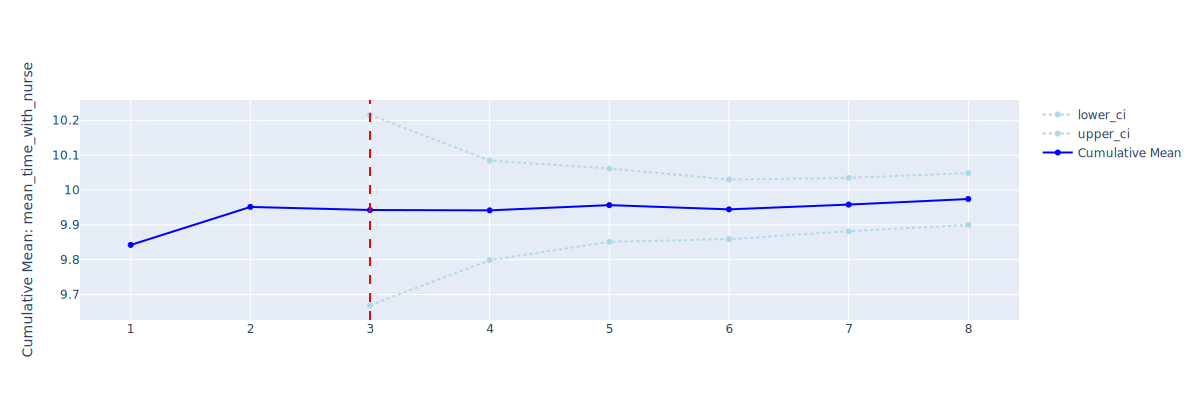

In [12]:
n_reps = analyser.select(runner=Runner(Param()),
                         metric='mean_time_with_nurse')
print(n_reps)
display(observer.summary_table())
plotly_confidence_interval_method(
    n_reps, observer.summary_table(), metric_name='mean_time_with_nurse')

31


,data,cumulative_mean,stdev,lower_ci,upper_ci,deviation
replications,,,,,,
1,0.501873,0.501873,NaN,NaN,NaN,NaN
2,0.516264,0.509069,NaN,NaN,NaN,NaN
3,0.531280,0.516472,0.014704,0.479945,0.553000,0.070725
4,0.491104,0.510130,0.017465,0.482339,0.537921,0.054479
5,0.463252,0.500755,0.025851,0.468656,0.532853,0.064100
6,0.390495,0.482378,0.050605,0.429272,0.535484,0.110092
7,0.473277,0.481078,0.046323,0.438236,0.523920,0.089054
8,0.611502,0.497381,0.062973,0.444734,0.550028,0.105848
9,0.478926,0.495330,0.059226,0.449805,0.540856,0.091909


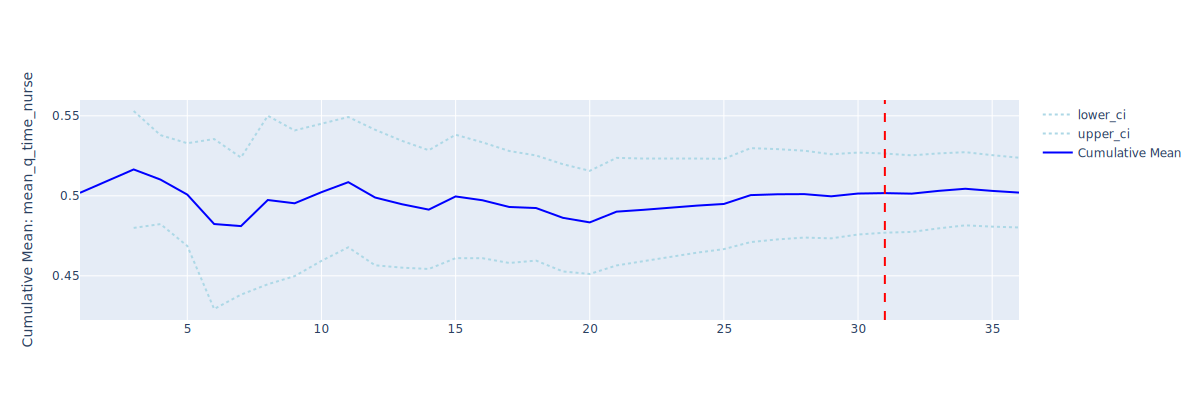

In [13]:
observer = ReplicationTabulizer()
analyser = ReplicationsAlgorithm(verbose=False, observer=observer)
n_reps = analyser.select(runner=Runner(Param()),
                         metric='mean_q_time_nurse')
print(n_reps)
display(observer.summary_table())
plotly_confidence_interval_method(
    n_reps, observer.summary_table(), metric_name='mean_q_time_nurse')

3


,data,cumulative_mean,stdev,lower_ci,upper_ci,deviation
replications,,,,,,
1,0.499589,0.499589,NaN,NaN,NaN,NaN
2,0.501977,0.500783,NaN,NaN,NaN,NaN
3,0.498094,0.499887,0.001959,0.495021,0.504753,0.009734
4,0.498249,0.499477,0.001797,0.496618,0.502336,0.005725
5,0.496934,0.498969,0.001928,0.496575,0.501362,0.004797
6,0.492854,0.497949,0.003034,0.494766,0.501133,0.006394
7,0.503386,0.498726,0.003448,0.495537,0.501915,0.006395
8,0.503411,0.499312,0.003597,0.496305,0.502319,0.006022


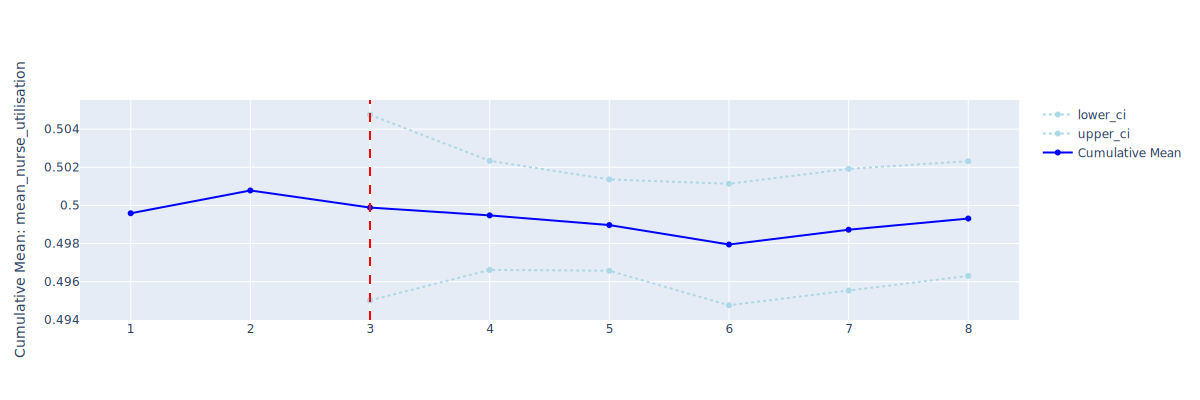

In [14]:
observer = ReplicationTabulizer()
analyser = ReplicationsAlgorithm(verbose=False, observer=observer)
n_reps = analyser.select(runner=Runner(Param()),
                         metric='mean_nurse_utilisation')
print(n_reps)
display(observer.summary_table())
plotly_confidence_interval_method(
    n_reps, observer.summary_table(), metric_name='mean_nurse_utilisation')

## Run time

In [15]:
# Get run time in seconds
notebook_end_time = time.time()
runtime = round(notebook_end_time - notebook_start_time)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime // 60}m {runtime % 60}s')

Notebook run time: 0m 14s
